# Data Preprocessing

In [1]:
from dask.distributed import Client
import dask.dataframe as dd
import time

client = Client()
client

Client Scheduler: tcp://127.0.0.1:41709 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 4.01 GB


## Convert Dataset Type ##
Convert bus CSV data to Parquet for more efficient operations on raw data

In [ ]:
df = dd.read_csv('./../data/mobility/bus_data.csv')
dd.to_parquet(df, './../data/mobility/bus_data.parquet', engine='pyarrow')

In [ ]:
!pwd
!ls ./../data/mobility/bus_data.parquet/

## Create 'timestamp' Index Column ##
Read the Parquet files back lazily as Dask.DataFrame and make a 'timestamp' column

In [2]:
df = dd.read_parquet('./../data/mobility/bus_data.parquet', engine='pyarrow')
df['timestamp'] = dd.to_datetime(df['date'] + ' ' + df['time'])
df

,date,time,order,line,latitude,longitude,speed,timestamp
npartitions=199,,,,,,,,
,object,object,object,object,float64,float64,float64,datetime64[ns]
,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


## Numify 'order' and 'line' ##
Find unique bus route names and bus license plate numbers and write them to a CSV file

In [ ]:
orders = df['order'].unique()
lines = df['line'].unique()

In [ ]:
orders.to_csv('./../data/mobility/orders.csv')
lines.to_csv('./../data/mobility/lines.csv')

Bring 'orders' and 'lines' sets back in the workspace as lists

In [3]:
orders_csv = dd.read_csv('./../data/mobility/orders.csv/0.part').compute()
lines_csv = dd.read_csv('./../data/mobility/lines.csv/0.part').compute()

orders = orders_csv['order'].values.tolist()
lines = lines_csv['line'].values.tolist()

Map element-wise the Dask.DataFrame of bus data to numify order/line information

In [4]:
df_new = df[['timestamp','order','line','latitude','longitude','speed']]
df_new['order'] = df['order'].map(lambda x: orders.index(x), meta=('order','int'))
df_new['line'] = df['line'].map(lambda x: lines.index(x), meta=('line','int'))

Write the transformed data into a parquet file

In [ ]:
dd.to_parquet(df_new, './../data/mobility/bus_data_clean.parquet', engine='pyarrow')

Remove no longer needed variables from the workspace to free up memory

In [ ]:
del orders, lines, orders_csv, lines_csv, df_new, df

## Interpolate and Time Syncrhonize ##
Load the cleaned dataset for interpolation

In [4]:
df = dd.read_parquet('./../data/mobility/bus_data_clean.parquet', engine='pyarrow')
df.head()

,timestamp,order,line,latitude,longitude,speed
0,2019-01-25 00:03:05,0,0,-22.816891,-43.301788,0.0
1,2019-01-25 00:07:29,1,1,-22.874250,-43.357971,37.0
2,2019-01-25 00:07:59,1,1,-22.880329,-43.357670,37.0
3,2019-01-25 00:17:31,2,2,-22.858509,-43.348221,59.0
4,2019-01-25 00:19:26,3,3,-22.883600,-43.552929,0.0


## Cleaned Data ##
Shapefile has a singly-linked list structure, while .shx has an array structure: each row entry of both correspond to the same record

```fiona``` takes advantage of the .shx accompanying file to offset into the binary .shp without parsing the entire set row-by-row 

```GeoPandas``` wraps ```fiona``` in its ```geopandas.read_file()``` producing an in-memory ```GeoDataFrame```

In [7]:
from dask.distributed import Client
import dask.dataframe as dd

client = Client()
client

Client Scheduler: tcp://127.0.0.1:45157 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 4.01 GB


In [4]:
import geopandas
import dask_geopandas
from dask.delayed import delayed
from shapely.geometry import LineString, Polygon, box
from shapely import wkb

Using ```Dask and GeoPandas```, read in ESRI Shapefile in partitions and construct a Dask Dataframe out of it, according to a neat prototype of Joris [geopandas/dask-geopandas#11](https://github.com/geopandas/dask-geopandas/issues/11#issue-638156319)

In [37]:
def read_file(path, npartitions):
    
    with fiona.open(path) as collection:
        total_size = collection.session.get_length()
    
    # TODO smart inference for a good default partition size
    batch_size = (total_size // npartitions) + 1
    
    row_offset = 0
    dfs = []
    
    while row_offset < total_size:
        rows = slice(row_offset, min(row_offset + batch_size, total_size))
        df = delayed(geopandas.read_file)(path, rows=rows)
        df1 = delayed(df.to_crs)(3857)
        dfs.append(df1)
        row_offset += batch_size
    
    # TODO this could be inferred from fiona's collection.meta["schema"]
    meta = geopandas.read_file(path, rows=5)
    
    return dd.from_delayed(dfs, meta)

```dask-geopandas``` manages the interpretation of the produced Dask GeoDataFrame and writes ```Shapely``` geometry as bytes for the later consumption

In [40]:
gdf = read_file('./../data/osm_roads/gis_osm_roads_free_1.shp', 24)
ddf = dask_geopandas.from_dask_dataframe(gdf)
ddf

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
npartitions=24,,,,,,,,,,,
,object,int64,object,object,object,object,int64,int64,object,object,geometry
,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...


In [41]:
ddf.to_parquet('./../data/osm_roads/roads.parquet')

For efficient geospatial queries of the road network dataset, R\*-tree is employed. It facilitates retreival of entries corresponding to the space of interest with complexity: ![](https://latex.codecogs.com/svg.latex?O(\log_M%20N))

The R\*-tree is composed of roads' bounding boxes, hence another step of processing of the converted Parquet data is required to precalculate it and clean up boolean and integer data from the original GEOFABRIK data

In [ ]:
import pandas as pd

def speed_limit(limit, code):
    if limit == 0:
        if code in [5141, 5142, 5143, 5144, 5145, 5146, 5147]: # Track/access roads, typically gravel or field
            return 10
        elif code in [5121, 5122, 5123, 5133, 5134, 5135]: # Minor roads and their links
            return 30
        elif code in [5113, 5114, 5115, 5131, 5132]: # Primary roads, their links and links of major highways
            return 60
        elif code in [5112]: # Urban highway
            return 80
        elif code in [5111]: # Suburban highway
            return 110
        else:
            return 0
    else:
        return limit

df = dd.read_parquet('./../data/osm_roads/roads.parquet', engine='pyarrow')

meta = {
    'bbox':'bytes',
    'oneway':'bool',
    'bridge':'bool',
    'tunnel':'bool',
    'geometry':'bytes',
    'maxspeed':'int'
}

index = [
    'bbox',
    'oneway',
    'bridge',
    'tunnel',
    'geometry',
    'maxspeed'
]

df[['bbox','oneway','bridge','tunnel','geometry','maxspeed']] = df.apply(
    lambda x: pd.Series([
        box(*wkb.loads(x.geometry).bounds).wkb,
        x.oneway != 'B',
        x.bridge == 'T',
        x.tunnel == 'T',
        LineString(wkb.loads(x.geometry).coords[:].reverse()).wkb if x.oneway == 'T' else x.geometry,
        speed_limit(x.maxspeed, x.code)
    ], index=index),
    axis=1,
    meta=meta)

df = df.astype({'osm_id':'int'})
df2 = df[df.maxspeed > 0].set_index('osm_id')

In [ ]:
dd.to_parquet(df2, './../data/osm_roads/roads_new.parquet', engine='pyarrow')

In [8]:
df = dd.read_parquet('./../data/osm_roads/roads_new.parquet', engine='pyarrow')
df.head()

,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry,bbox
osm_id,,,,,,,,,,,
4217292,5122,residential,Rua Vinícius de Moraes,None,True,30,0,False,False,b'\x01\x02\x00\x00\x00\r\x00\x00\x00``\xe1\xf0...,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...
4217293,5122,residential,Rua Joana Angélica,None,True,30,0,False,False,b'\x01\x02\x00\x00\x00\x13\x00\x00\x00\xc8\x99...,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...
4217294,5122,residential,Rua Farme de Amoedo,None,False,30,0,False,False,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\xde\x00...,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...
4217295,5122,residential,Rua Teixeira de Melo,None,True,30,0,False,False,b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\x1255\x...,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...
4217297,5122,residential,Rua Maria Quitéria,None,True,30,0,False,False,"b""\x01\x02\x00\x00\x00\x10\x00\x00\x00\x8fP\x9...",b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...


Now the data is in the ideal form to construct the R\*-tree and shuffle the data in the ```DataFrame``` accordingly. First the R\*-tree is bulk loaded top-down according to the [OMT method](http://ftp.informatik.rwth-aachen.de/Publications/CEUR-WS/Vol-74/files/FORUM_18.pdf)

However, for the sake of time, the custom dask-friendly OMT implementation is postponed and instead the functionality of ```libspatialindex``` Python wheel ```rtree``` is taken advantage of. It generates a separate index data structure out of the unique integer indices and bounding boxes that are provided to it. The resulting R-tree can later be queried using a bounding box of interest in which case it returns integer IDs intersecting the area of interest

To efficiently and trivially seek the Dask Dataframe entries, the ```osm_id``` is passed as the identifier for each bounding box upon R-tree entry insertion, which can then be directly used to index into the out-of-core dataframe. It is important that before insertion, the street segment coordinates be projected into the same CRS as the one used for the Dask Dataframe entries.

In [45]:
import pyproj
from shapely.geometry import LineString, Polygon, Point, box
from shapely.ops import transform
from shapely import wkb
import fiona
import rtree
import time
import numpy as np
import pandas as pd
import networkx as nx

In [18]:
%%time

wgs84 = pyproj.CRS('EPSG:4326')
pseudo_mercator = pyproj.CRS('EPSG:3857')

project = pyproj.Transformer.from_crs(wgs84, pseudo_mercator, always_xy=True).transform

with fiona.open('./../data/osm_roads/gis_osm_roads_free_1.shp') as layer_roads:
    index = rtree.index.Rtree('roads')

    for entry in layer_roads:
        if entry['properties']['code'] in [5141, 5142, 5143, 5144, 5145, 5146, 5147, 5121, 5122, 5123, 5133, 5134, 5135, 5113, 5114, 5115, 5131, 5132, 5112, 5111]:
            line = transform(project, LineString(entry['geometry']['coordinates']))
            osm_id = int(entry['properties']['osm_id'])
            index.insert(osm_id, line.bounds)

CPU times: user 18min 57s, sys: 44.2 s, total: 19min 41s
Wall time: 18min 37s


Once the index is constructed, it is serialized to disk and can be later retreived again using the same ```rtree.index.Rtree('rtree_name')``` constructor. To verify that the index is correct, list length of the index intersection with its own bounds can be performed. It returns the same number of entries as the original shapefile using ```len(fiona.open(filename.shp))```

In fact, since non-routable roads like pedestrian-only, bridleways, footways, cycleways, etc. were filtered out in the step above, the R-tree index is smaller than the original shapefile from GEOFABRIK by 89'433 entries

In [19]:
layer_roads = fiona.open('./../data/osm_roads/gis_osm_roads_free_1.shp')
print(len(layer_roads) - index.count(index.bounds))
layer_roads.close()

89433


```find_intersections()``` func maps every Dask Dataframe road entry into a list of street intersections (nodes) and links between them (edges). It uses R-Tree index generated above to obtain list of osm_id's whose bounding boxes spatially intersect the bounding box of the road the dataset is tested against. 

The resulted handful of osm_id's are used for constant time trivial retrieval of the corresponding entry from the Dask Dataframe to test for actual intersection and composure of the list of node/edge tuples, which will later be fed into the NetworkX graph construction functions. 

A new Dask Dataframe results from it which is then iterated over to construct a MultiDiGraph of the road network with multiple edge attributes for multi-criteria routing

In [1]:
from dask.distributed import Client
import dask.dataframe as dd
from shapely.geometry import LineString, Polygon, Point, box
from shapely import wkb
import rtree
import time
import pandas as pd
import networkx as nx
import rasterio
from rasterio.plot import show

client = Client(memory_limit='4GB')
client

Client Scheduler: tcp://127.0.0.1:42183 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 16.00 GB


Using ```rasterio``` reproject GeoTIFF Digital Elevation Model raster files from EPSG:4326 to EPSG:3857 coordinate system. This can however be done only after merging together rasters since after transformation of each tile, their sizes would no longer be equal

In [25]:
from osgeo import gdal
import pprint
import os
from rasterio.transform import Affine
import re
import numpy as np

In [68]:
files = []
for i in range(1,6):
    for k in range(1,9):
        files.append('S02'+str(i)+'W04'+str(k))

data_files = os.listdir('./../data/aw3d30_elevation')
for file in files: 
    if file not in data_files:
        s = re.findall('[1-9]{2}', file)
        
        Z = np.zeros((dataset.height, dataset.width), dtype=np.int16)
        
        os.mkdir('./../data/aw3d30_elevation/'+file)
        
        dataset = rasterio.open(
            './../data/aw3d30_elevation/'+file+'/ALPSMLC30_'+file+'_DSM.tif',
            'w',
            driver='GTiff',
            height=Z.shape[0],
            width=Z.shape[1],
            count=1,
            dtype=Z.dtype,
            crs='+proj=latlong',
            transform=Affine(0.0002777777777777778, 0.0, -float(s[1]), 0.0, -0.0002777777777777778, -float(s[0])),
        )

        dataset.write(Z, 1)
        dataset.close()

In [78]:
dem_list = ['./../data/aw3d30_elevation/'+file+'/ALPSMLC30_'+file+'_DSM.tif' for file in os.listdir('./../data/aw3d30_elevation')]
dem_list.sort()

cmd = 'gdal_merge.py -o ./../data/elevation/mergedDEM.tif ' + ' '.join(dem_list)
os.system(cmd)

0

The DEM is now merged. Next step is to reproject it to a different CRS, namely EPSG:3857

In [84]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = 'EPSG:3857'

with rasterio.open('./../data/elevation/mergedDEM.tif') as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open('./../data/elevation/mergedReprojDEM.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

dataset = rasterio.open('./../data/elevation/mergedReprojDEM.tif')

The resulting GeoTIFF of the region can be plotted and some basic details of the DEM can be reported

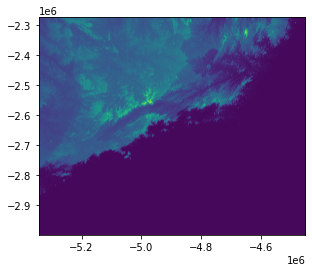

<AxesSubplot:>

In [2]:
show(dataset.read(), transform=dataset.transform)

In [29]:
pprint.pprint({
    'crs': dataset.crs,
    'transform': dataset.transform,
    'width': dataset.width,
    'height': dataset.height,
    'bounds': dataset.bounds
})

dataset.close()

{'bounds': BoundingBox(left=-5343335.558077134, bottom=-2999081.567456966, right=-4452784.082326574, top=-2273030.92698769),
 'crs': CRS.from_epsg(3857),
 'height': 22748,
 'transform': Affine(31.917119767420253, 0.0, -5343335.558077134,
       0.0, -31.917119767420253, -2273030.92698769),
 'width': 27902}


In [2]:
import xarray as xr

index = rtree.index.Rtree('roads')
df = dd.read_parquet('./../data/osm_roads/roads_new.parquet', engine='pyarrow')
dataset = rasterio.open('./../data/elevation/mergedReprojDEM.tif')
dem = xr.open_rasterio('./../data/elevation/mergedReprojDEM.tif', chunks={'band':1, 'x': 3986, 'y': 5687})
dem

<xarray.DataArray (band: 1, y: 22748, x: 27902)>
dask.array<open_rasterio-2a721fd7bc0c5f089294c6ccfeb50abf<this-array>, shape=(1, 22748, 27902), dtype=int16, chunksize=(1, 5687, 3986), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 -2.273e+06 -2.273e+06 ... -2.999e+06 -2.999e+06
  * x        (x) float64 -5.343e+06 -5.343e+06 ... -4.453e+06 -4.453e+06
Attributes:
    transform:      (31.917119767420253, 0.0, -5343335.558077134, 0.0, -31.91...
    crs:            +init=epsg:3857
    res:            (31.917119767420253, 31.917119767420253)
    is_tiled:       0
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

The ```find_intersections()``` func is applied to each Dask Dataframe row and a new Dask Dataframe of ```Graph``` and ```None``` entries is retuned

As mentioned prior, ```MultiDiGraph``` is a directional graph with more than 1 link between any 2 nodes: its use allows to recreate the street traffic flow rules for oneway and twoway streets. The graph is constructed by iterating over Dask Dataframe and loading edges into the graph. Missing node attributes for completeness are later added as well

In [3]:
def find_intersections(row, ddf, geo_index, dataset, dem):
    nodes = [] # Arrays of tuples for NetworkX MultiDiGraph
    edges = []
    
    if not (row.bridge or row.tunnel): # We assume bridges and tunnels do not have intersections
        fids = [int(i) for i in geo_index.intersection(wkb.loads(row.bbox).bounds)] # Query R-Tree by the bounding box of road 'x'
        if not fids:
            return nodes, edges
        
        a = wkb.loads(row.geometry)
        road = a.coords[:]
        intersections = [] # Container for street intersections
        
        for fid in fids:
            if row.Index != fid:
                entry = ddf.loc[fid].compute().iloc[0] # Retreive each road record from Dask Dataframe by osm_id if it is not the road 'x' itself
                b = wkb.loads(entry.geometry)
                if not (entry.bridge or entry.tunnel) and a.intersects(b): # Check if road with 'fid' osm_id actually intersects road 'x'
                    pts = a.intersection(b)
                    if pts.type == 'MultiPoint':
                        (nodes.append(
                            (pt.coords[:][0], {
                                'junction':[row.Index, fid],
                                'altitude':dem[(0, *dataset.index(*(pt.coords[:][0])))].compute().data.item()
                            })) for pt in pts)
                        (intersections.append(pt) for pt in pts if pt.coords[:][0] != road[0] and pt.coords[:][0] != road[-1] and (pt.coords[:][0] not in intersections))
                    elif pts.type == 'Point':
                        nodes.append(
                            (pts.coords[:][0], {
                                'junction':[row.Index, fid],
                                'altitude':dem[(0, *dataset.index(*(pts.coords[:][0])))].compute().data.item()
                            }))
                        if pts.coords[:][0] != road[0] and pts.coords[:][0] != road[-1] and (pts.coords[:][0] not in intersections):
                            intersections.append(pts)

        segment_len = 0
        segment_flatness = 0
        previous_node_elevation = dem[(0, *dataset.index(*(road[0])))].compute().data.item()
        previous_node = road[0] # Coordinate keeping track of previous intersection/edge end

        for idx in range(len(road)-1):
            segment = LineString(road[idx:idx+2]) # LineString of straight line segment between two consecutive points
            segment_start = road[idx] # Coordinate updating on every segment or when intersection encountered
            queue = [] # Point objects that intersect this particular road straight line segment

            for pt in list(intersections):
                if segment.intersects(pt):
                    queue.append(pt) # Put all junctions intersecting this segment into a queue
                    intersections.remove(pt) # Remove the junction from left-over list of street intersections

            if not queue:
                segment_len += segment.length # If no junctions in this road segment, increase length by distance between LineString consecutive points
                next_node_elevation = dem[(0, *dataset.index(*(road[idx+1])))].compute().data.item()
                segment_flatness += (previous_node_elevation - next_node_elevation) ** 2 
                previous_node_elevation = next_node_elevation
            else:
                for pt in list(queue):
                    line_lengths = [LineString([segment_start, p.coords[:][0]]).length for p in queue]
                    shortest_line = min(line_lengths)

                    next_node_idx = [k for k, l in enumerate(line_lengths) if l == shortest_line][0]
                    next_node = queue[next_node_idx].coords[:][0]
                    
                    segment_len += LineString([segment_start, next_node]).length
                    
                    if segment_len: # Multiple roads crossing at the same junction. Can skip. osm_id's on intersectinos are maintained by nodes array
                        next_node_elevation = dem[(0, *dataset.index(*(next_node)))].compute().data.item()
                        segment_flatness += (previous_node_elevation - next_node_elevation) ** 2 
                        previous_node_elevation = next_node_elevation

                        edges.append((
                            previous_node,
                            next_node,
                            {
                                'length':segment_len,
                                'weight':segment_len/row.maxspeed/1000,
                                'flatness':segment_flatness/segment_len
                            }))

                        if not row.oneway: # If both way street, add identical reverse relation between MultiDiGraph nodes
                            edges.append((
                                next_node,
                                previous_node,                          
                                {
                                    'length':segment_len,
                                    'weight':segment_len/row.maxspeed/1000,
                                    'flatness':segment_flatness/segment_len
                                }))

                    segment_len = 0
                    segment_flatness = 0
                    previous_node = next_node
                    segment_start = next_node
                    queue.remove(queue[next_node_idx]) # Remove the junction from the queue

                segment_len += LineString([segment_start, road[idx+1]]).length # Get distance to the endpoint of the segment
                next_node_elevation = dem[(0, *dataset.index(*(road[idx+1])))].compute().data.item()
                segment_flatness += (previous_node_elevation - next_node_elevation) ** 2 
                previous_node_elevation = next_node_elevation

        edges.append((
            previous_node,
            road[-1],
            {
                'length':segment_len,
                'weight':segment_len/row.maxspeed/1000,
                'flatness':segment_flatness/segment_len
            }))

        if not row.oneway: # If both way street, add identical reverse relation between MultiDiGraph nodes
            edges.append((
                road[-1],
                previous_node,            
                {
                    'length':segment_len,
                    'weight':segment_len/row.maxspeed/1000,
                    'flatness':segment_flatness/segment_len
                }))
                
    return nodes, edges
    
    
def construct_graphs(ddf, path_df, index, path_dem, dem):
    with rasterio.open(path_dem) as dataset:
        G = nx.MultiDiGraph()
        df = dd.read_parquet(path_df, engine='pyarrow')
        for row in ddf.itertuples():
            (nodes, edges) = find_intersections(row, df, index, dataset, dem)

            if edges and nodes:
                G.add_edges_from(edges) # Creates nodes if they do not exist, creates an edge with attributes between them
                for node in nodes: # Loops over affected new or existing nodes
                    if 'junction' not in G.nodes[node[0]]:
                        G.nodes[node[0]]['junction'] = []
                    if 'altitude' not in G.nodes[node[0]]:
                        G.nodes[node[0]]['altitude'] = node[1]['altitude']
                    # Updates their attributes with 'osm_id' of streets causing intersection
                    (G.nodes[node[0]]['junction'].append(osm_id) for osm_id in node[1]['junction'] if osm_id not in G.nodes[node[0]]['junction'])
    return G

#### Parallelized Graph building approach ####
Using dd.apply() caused serialization/pickling errors: partition mapping approach was attempted instead. This effectively splits task into 24 parallel tasks (equal to #partitions of the roads Dask Dataframe). However, beacuse ```find_intersections``` envokes ```compute()``` on DEM Dask XArray and roads Dask Dataframe, the scheduler becomes overwhelmed with the increasing number of tasks asking to acquire read/write locks to the data as Dask starts a new task for nearly every indexing operation and utilizes only 10% of CPU. Hence it suffocates itself. It was chosen to follow the sequential approach instead to avoid this bottleneck for this seemingly trivially parallelizable task

In [ ]:
%%time

# "Parallelized" find_intersections - because of DataFrame.loc(), effectively only 1 core performs work
partition_graphs = df.map_partitions(
    construct_graphs,
    path_df='./../data/osm_roads/roads_new.parquet',
    index=index,
    path_dem='./../data/elevation/mergedReprojDEM.tif',
    dem=dem,
    meta=('graph','object')
)

G = nx.MultiDiGraph()

for H in partition_graphs:
    if H:
        for edge in H.edges:
            for sub_edge in G[edge[0]][edge[1]]:
                G.add_edge(edge[0], edge[1], G[edge[0]][edge[1]][sub_edge]) # Inserts partition's edges with attributes
        for node in H.nodes: # Loops over affected new or existing nodes
            if 'junction' not in G.nodes[node[0]]:
                G.nodes[node[0]]['junction'] = []
            if 'altitude' not in G.nodes[node[0]]:
                G.nodes[node[0]]['altitude'] = node[1]['altitude']
            # Updates their attributes with 'osm_id' of streets causing intersection
            (G.nodes[node[0]]['junction'].append(osm_id) for osm_id in node[1]['junction'] if osm_id not in G.nodes[node[0]]['junction'])

#### Sequential Graph building approach ####
It works successfully, but takes a long time and never completed in previous attempts, potentially because of exceeding memory limitation about 2-3 hours after starting the process

In [4]:
%%time

G = nx.MultiDiGraph()

# Non-parallelized find_intersections
for row in df.itertuples():
    (nodes, edges) = find_intersections(row, df, index, dataset, dem)
    
    if edges and nodes:
        G.add_edges_from(edges) # Creates nodes if they do not exist, creates an edge with attributes between them
        for node in nodes: # Loops over affected new or existing nodes
            if 'junction' not in G.nodes[node[0]]:
                G.nodes[node[0]]['junction'] = []
            if 'altitude' not in G.nodes[node[0]]:
                G.nodes[node[0]]['altitude'] = node[1]['altitude']
            # Updates their attributes with 'osm_id' of streets causing intersection
            (G.nodes[node[0]]['junction'].append(osm_id) for osm_id in node[1]['junction'] if osm_id not in G.nodes[node[0]]['junction'])

OSError: Timed out trying to connect to tcp://127.0.0.1:42183 after 10 s

In [ ]:
for edge in G.edges:
    for e in G[edge[0]][edge[1]]:
        print(edge[0],edge[1],G[edge[0]][edge[1]][e])
        
for node in G.nodes:
    print(node, G.nodes[node])

In [ ]:
len(G.nodes)

440

In [8]:
len(G.edges)

383

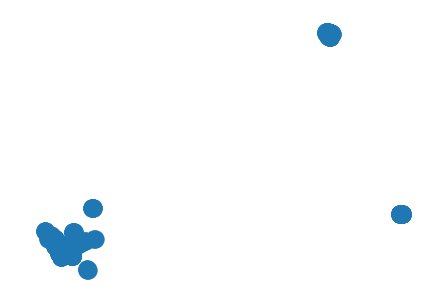

In [6]:
pos=dict()
for node in G.nodes:
    pos[node]=node
    
nx.draw(G, pos=pos)

In [7]:
from pyproj import Transformer
import folium

m = folium.Map(location=[-22.983840,-43.211162], zoom_start=15)

transformer = Transformer.from_crs("EPSG:3857","EPSG:4326")

for node in G.nodes:
    folium.Marker(transformer.transform(*node)).add_to(m)
    
m

In [ ]:
client.shutdown()